In [1]:
import pandas as pd
import os
import networkx as nx
import itertools
from netwulf import visualize
from collections import Counter

In [2]:
os.getcwd()

'C:\\Users\\mansj\\IQL\\ExRx Data Quality'

Oversplitting issue on the final manually corrected file
- Authors having same co-authors or connected in the graph component with same nodes

In [3]:
author_df = pd.read_csv("C:\\Users\\mansj\\IQL\\data\\databank_deposit_version_2\\exrx_author_final.csv")

Add full name column for further analysis

In [4]:
author_df["full_name"] = author_df['author_given_name'] + " " + author_df['author_surname'].fillna('')
author_df.head()

,ID,Title,author_given_name,author_surname,author_id,full_name
0,1,Physical activity in depressed elderly. a syst...,Gioia,Mura,7005321937,Gioia Mura
1,1,Physical activity in depressed elderly. a syst...,Mauro Giovanni,Carta,7006714673,Mauro Giovanni Carta
2,2,Exercise for depression,Gary. M.,Cooney,26028761700,Gary. M. Cooney
3,2,Exercise for depression,Kerry,Dwan,25027473800,Kerry Dwan
4,2,Exercise for depression,Carolyn A.,Greig,7003441733,Carolyn A. Greig


In [5]:
#Author with same id have different names
author_df[author_df.author_id == 7201720357]

,ID,Title,author_given_name,author_surname,author_id,full_name
46,11,Moderators of response in exercise treatment f...,A. L.,Dunn,7201720357,A. L. Dunn
146,26,Physical activity and incident depression: a m...,Andrea L.,Dunn,7201720357,Andrea L. Dunn
391,88,Exercise and depression: meeting standards to ...,A.,Dunn,7201720357,A. Dunn
429,95,The DOSE study: a clinical trial to examine ef...,Andrea L.,Dunn,7201720357,Andrea L. Dunn
484,106,Exercise treatment for depression: Efficacy an...,Andrea L.,Dunn,7201720357,Andrea L. Dunn
1094,219,Exercise as an augmentation treatment for nonr...,Andrea L.,Dunn,7201720357,Andrea L. Dunn
2502,108,The effect of exercise dose on quality of life...,AL,Dunn,7201720357,AL Dunn


In [6]:
list_authors  = pd.DataFrame(author_df.groupby('author_id')['full_name'].apply(list))
list_authors.head()

,full_name
author_id,
1,[Yunqiao Sun]
2,[Haiyan Yin]
3,[Baiqing Zhao]
4,[Yanqiang Liao]
5,[Qingkui Lin]


In [7]:
# Convert it to a list and then to a dictionary to replace the author names with one common name
auth_list = list_authors.full_name.to_list()

auth_dict = dict()

for i in auth_list:
    i = list(set(i))
    if len(i) > 1:
        auth_dict[i[0]] = i[1:]

In [8]:
#replaces the names of author with same id with the selected key in the dictionary
def replace(auth_name, final_dict):
    for k, v in final_dict.items():
        if auth_name in v:
            auth_name = k
            
    return auth_name
    

author_df.full_name = author_df.full_name.apply(lambda x : replace (x, auth_dict))

In [9]:
#Check if the author names are changed to one name
author_df[author_df.author_id == 7201720357]

,ID,Title,author_given_name,author_surname,author_id,full_name
46,11,Moderators of response in exercise treatment f...,A. L.,Dunn,7201720357,A. L. Dunn
146,26,Physical activity and incident depression: a m...,Andrea L.,Dunn,7201720357,A. L. Dunn
391,88,Exercise and depression: meeting standards to ...,A.,Dunn,7201720357,A. L. Dunn
429,95,The DOSE study: a clinical trial to examine ef...,Andrea L.,Dunn,7201720357,A. L. Dunn
484,106,Exercise treatment for depression: Efficacy an...,Andrea L.,Dunn,7201720357,A. L. Dunn
1094,219,Exercise as an augmentation treatment for nonr...,Andrea L.,Dunn,7201720357,A. L. Dunn
2502,108,The effect of exercise dose on quality of life...,AL,Dunn,7201720357,A. L. Dunn


In [10]:
#Check if the author with same id are replaced with a common name
id_df_1 = author_df[['author_id','full_name']]
merged_df_1 = id_df_1.merge(id_df_1, how='left', left_on='author_id', right_on='author_id')
auth_dict_1= merged_df_1[merged_df_1['full_name_x'] != merged_df_1['full_name_y']]
auth_dict_1

,author_id,full_name_x,full_name_y


#### Create a graph and check oversplitting in netwulf by hovering over the names in the same cluster

In [11]:
author_df.to_csv("check_replaced_name.csv")

In [12]:
# Create the nodes and edges of the graph from the given dataframe by grouping on the paper ID
G = nx.Graph()


In [13]:
edges = pd.DataFrame(author_df.groupby('ID')['full_name'].apply(list))['full_name'].to_list()

In [14]:
new  = []
for i in edges:
    if len(i) >= 2:
        for subset in itertools.combinations(i,2):
            if len(subset) == 2:
                new.append(subset)
sorted_list = []
for i in new:
    sorted_list.append(tuple(sorted(list(i))))
    
count_auth = Counter(sorted_list)

In [15]:
for k, v in count_auth.items():
    G.add_edge(k[0], k[1],  weight = v,  length = v)
G.remove_nodes_from(list(nx.isolates(G)))

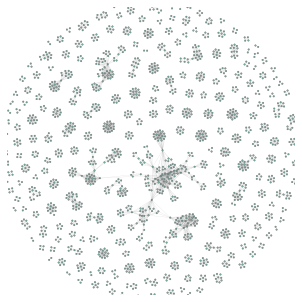

In [16]:
styled_network, config = visualize(G)


Found one oversplitting issue for an author having the same connected nodes in the graph (Checked it through netwulf by hovering over the names).
- Mueller, Hans-Josef and Müller, Hans-Josef

Corrected this manually, exrx_author_final.csv